In [1]:
import torch
from torch import Tensor

In [2]:
torch.__version__

'0.3.1.post2'

In [3]:
from torch.autograd import Variable

In [4]:
import numpy as np

In [5]:
import sys, inspect
sys.path.insert(0, '..')

In [6]:
%matplotlib inline
# import pymc
import matplotlib.pyplot as plt

# from learn_smc_proposals import cde
# from learn_smc_proposals.utils import systematic_resample

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

import scipy.stats as stats
import scipy.special as special
import scipy

In [63]:
plt.rcParams["figure.figsize"] = (6,4)

In [8]:
l = 4
n = 1000
x = np.linspace(-l, l, n)
p = (x>1) * stats.norm(loc=0, scale=1).pdf(x)

q = lambda mu, sigma: stats.norm(loc=mu, scale=sigma).pdf(x)
res = scipy.optimize.minimize(fun=lambda args: stats.entropy(p, q(args[0], args[1])), x0=[1, 1], method='Nelder-Mead')
mu_q, sigma_q = res.x

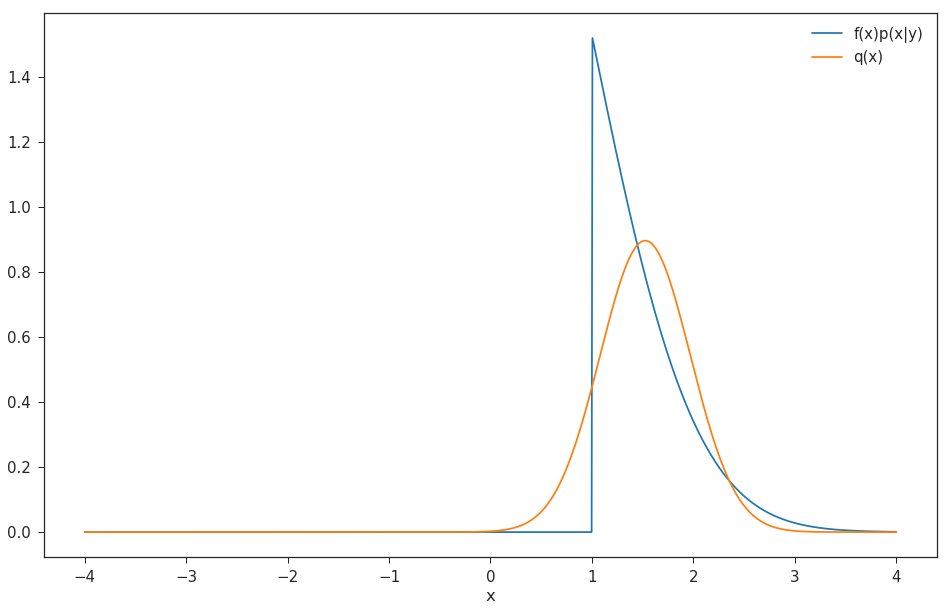

mu_q 1.53, sigma_q 0.44


In [9]:
plt.plot(x, p/sum(p*(2*l/n)), label='f(x)p(x|y)')
plt.plot(x, q(mu_q, sigma_q), label='q(x)')

plt.legend()
plt.xlabel('x')
plt.show()

print("mu_q {:.2f}, sigma_q {:.2f}".format(mu_q, sigma_q))

In PyTorch

In [10]:
l = 4
n = 1000
x = Variable(torch.linspace(-l, l, n))
p = (x<1).float() * -1e38 + torch.distributions.Normal(0, 1).log_prob(x)

mean = Variable(Tensor([0]), requires_grad=True)
std = Variable(Tensor([1]), requires_grad=True)

optimizer = torch.optim.Adam([mean, std], lr = 0.01)

for t in range(500):
    q = torch.distributions.Normal(mean, std).log_prob(x)
    loss = torch.dot(p.exp(), p-q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
mean, std

(Variable containing:
  1.5254
 [torch.FloatTensor of size 1], Variable containing:
  0.4445
 [torch.FloatTensor of size 1])

In [11]:
l = 4
n = 1000
x = Variable(torch.linspace(-l, l, n)).cuda()
p = (x<1).float() * -1e38 + torch.distributions.Normal(0, 1).log_prob(x)

mean = Variable(Tensor([0]).cuda(), requires_grad=True)
std = Variable(Tensor([1]).cuda(), requires_grad=True)

optimizer = torch.optim.Adam([mean, std], lr = 0.01)

for t in range(500):
    q = torch.distributions.Normal(mean, std).log_prob(x)
    loss = torch.dot(p.exp(), p-q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
mean, std

(Variable containing:
  1.5254
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.4445
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [12]:
mu_q, sigma_q

(1.5253753234329335, 0.44449892501091853)

# Model

\begin{align}
p(x) &= \mathcal{N}(x; 0, 1) \\
p(y|x) &= \mathcal{N}(y; x, 1) \\
p(x|y) &= \mathcal{N}(x; \frac{y}{2}, \frac{1}{2})\\
q_\phi(x|y) &= \mathcal{N}\left(x; \eta(y; \phi) \right) \\
f(x;\theta) &= \mathbb{1}_{x>\theta}\\
\\
\theta &\sim \text{Uniform}[-5,5]\\
\end{align}

Posterior is determined analytically

Optimizing the objective function
\begin{align}
\mathbb{E}_{p(y)\,p(\theta)}\left[D_{KL} \left[ f(x;\theta) \, p(x|y) \mid\mid q(x|y) \right]\right]
&=& \int D_{KL} \left[ f(x;\theta) \, p(x|y) \mid\mid q(x|y) \right] p(y) p(\theta) \, \text{d}y \, \text{d}\theta \\
&=& \int p(x,y) p(\theta) \, f(x;\theta) \log \frac{f(x;\theta)p(x|y)}{q(x|y;\phi)} \, \text{d}x \, \text{d}y \, \text{d}\theta \\
&=& \text{constant wrt }\phi - \int p(x,y) p(\theta) \, f(x;\theta) \log q(x|y;\phi) \, \text{d}x \, \text{d}y \, \text{d}\theta \\
&=& \mathbb{E}_{p(x,y)\,p(\theta)}\left[-f(x; \theta) \log q(x \mid y;\phi)\right]
\end{align}

In [13]:
batch_size = 3000
epochs = 1000
H = 10

# input: y, theta
phi = torch.nn.Sequential(
          torch.nn.Linear(2, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, 2),
        )
phi.cuda()

f = lambda x, theta: (x>theta).float()

optimizer = torch.optim.Adam(phi.parameters(), lr = 0.001)

In [14]:
# Number of parameters in the model

from functools import reduce
from operator import mul
sum([reduce(mul, list(tensorr.size())) for tensorr in phi.parameters()])

162

In [15]:
def change_lr(optimizer, lr):
    state_dict = optimizer.state_dict()
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)

In [20]:
for e in range(epochs):
#     x = Variable(torch.distributions.Normal(0, 1).sample((batch_size,)))
    
    theta = Variable(Tensor((scipy.rand(batch_size,1)-0.5)*10).cuda())

    x = Variable(torch.distributions.Normal(0, 1).sample_n(batch_size)).cuda()
    y = torch.distributions.Normal(x, 1).sample()
    
#     q_mean, q_log_std = phi(y.unsqueeze(1)).split(1, dim=1)
    q_mean, q_log_std = phi(torch.cat((y, theta), 1)).split(1, dim=1)
    q_std = q_log_std.exp()
    q = torch.distributions.Normal(q_mean, q_std)
    loss = -torch.mean(f(x, theta) * q.log_prob(x))
#     print(e, loss.data[0].numpy()) if e%1==0 else None
    print(e, loss.data[0]) if e%100==0 else None
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.8663047552108765
100 0.6833438277244568
200 0.5329267382621765
300 0.5227101445198059
400 0.5022616386413574
500 0.4855811297893524
600 0.5068842768669128
700 0.4975440204143524
800 0.47628799080848694
900 0.4974443316459656


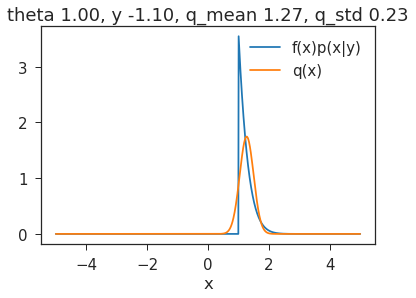

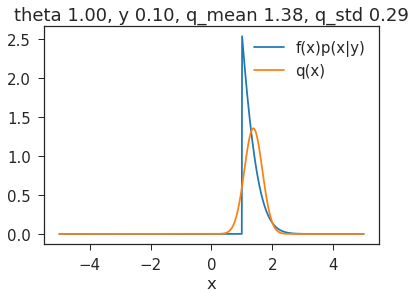

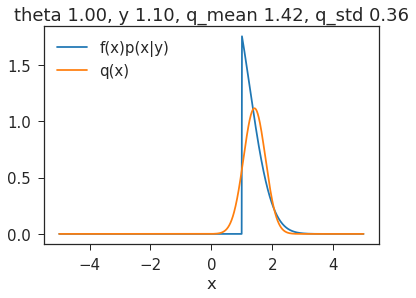

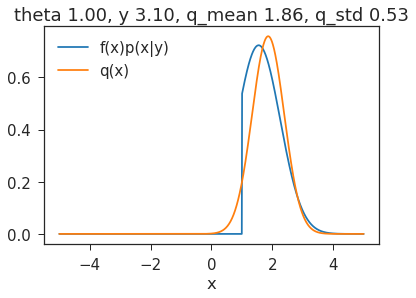

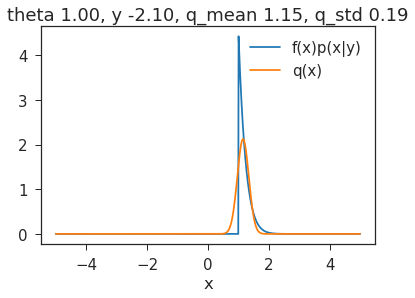

In [66]:
theta = Variable(torch.ones(5,1).cuda())
y = Variable(Tensor([[-1.1, 0.1, 1.1, 3.1, -2.1]])).transpose(0,1).cuda()

q_mean, q_log_std = phi(torch.cat((y, theta), 1)).split(1, dim=1)
q_std = q_log_std.exp()

q_mean, q_std

l = 5
n = 1000
x = np.linspace(-l, l, n)

q = lambda mu, sigma: stats.norm(loc=mu, scale=sigma).pdf(x)

for itheta, iy, iq_mean, iq_std in zip(*[i.cpu().data.numpy().flatten() for i in [theta, y, q_mean, q_std]]):
    # analytical posterior
    py = (x>itheta) * stats.norm(loc=iy/2, scale=1/np.sqrt(2)).pdf(x)
    
    plt.plot(x, py/sum(py*(2*l/n)), label='f(x)p(x|y)')
    plt.plot(x, q(iq_mean, iq_std), label='q(x)')

    plt.legend()
    plt.xlabel('x')
    plt.title('theta {:.2f}, y {:.2f}, q_mean {:.2f}, q_std {:.2f}'.format(itheta, iy, iq_mean, iq_std))
    plt.show()

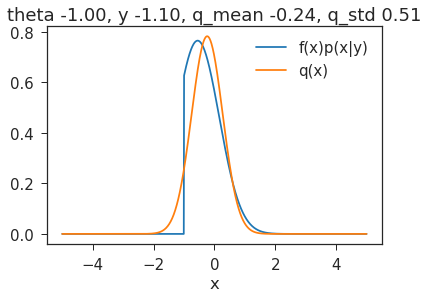

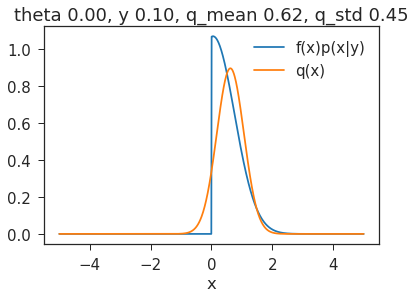

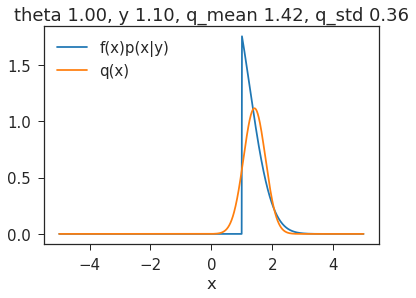

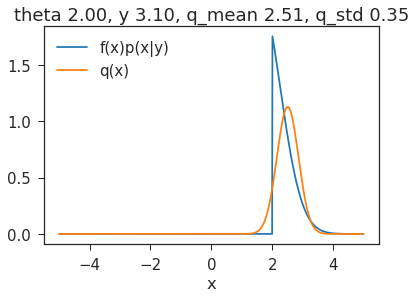

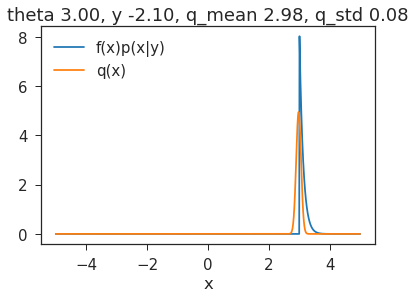

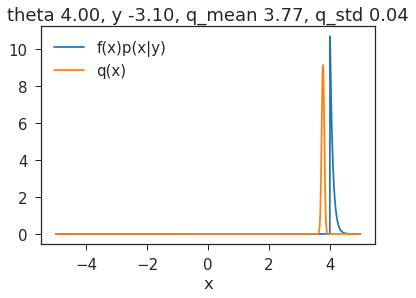

In [78]:
theta = Variable(torch.arange(-1,5).unsqueeze(1).cuda())
y = Variable(Tensor([[-1.1, 0.1, 1.1, 3.1, -2.1, -3.1]])).transpose(0,1).cuda()

q_mean, q_log_std = phi(torch.cat((y, theta), 1)).split(1, dim=1)
q_std = q_log_std.exp()

q_mean, q_std

l = 5
n = 1000
x = np.linspace(-l, l, n)

q = lambda mu, sigma: stats.norm(loc=mu, scale=sigma).pdf(x)

for itheta, iy, iq_mean, iq_std in zip(*[i.cpu().data.numpy().flatten() for i in [theta, y, q_mean, q_std]]):
    # analytical posterior
    py = (x>itheta) * stats.norm(loc=iy/2, scale=1/np.sqrt(2)).pdf(x)
    
    plt.plot(x, py/sum(py*(2*l/n)), label='f(x)p(x|y)')
    plt.plot(x, q(iq_mean, iq_std), label='q(x)')

    plt.legend()
    plt.xlabel('x')
    plt.title('theta {:.2f}, y {:.2f}, q_mean {:.2f}, q_std {:.2f}'.format(itheta, iy, iq_mean, iq_std))
    plt.show()

May want to substitute fully connected with a NF

# Try pyro IAFs

In [12]:
import pyro
from pyro.distributions.transformed_distribution \
    import InverseAutoregressiveFlow, TransformedDistribution
pyro.__version__

'0.1.2'

In [13]:
mean = Variable(Tensor([0]), requires_grad=True).cuda()
std = Variable(Tensor([1]), requires_grad=True).cuda()

base_dist = pyro.distributions.Normal(mean, std)

In [14]:
iaf = InverseAutoregressiveFlow(input_dim=2, hidden_dim=1)

In [15]:
dist = TransformedDistribution(base_dist, [iaf])

In [22]:
dist.sample()

AttributeError: 'TransformedDistribution' object has no attribute 'bijectors'

In [18]:
x = Variable(Tensor([[0]]))
dist.log_pdf(x)

AttributeError: 'TransformedDistribution' object has no attribute 'bijectors'

\begin{align}
p(x) &= \mathcal{N}(x; \mu_x, \sigma_x^2) \\
p(y|x) &= \mathcal{N}(y; x, \sigma_y^2) \\
p(x|y) &= \mathcal{N}(x; \frac{y}{2}, \frac{1}{2})\\
q_\phi(x|y) &= \mathcal{N}\left(x; \eta(y; \phi) \right) \\
f(x;\theta) &= \mathbb{1}_{x>\theta}\\
\\
\theta &\sim \text{Uniform}[-5,5]\\
\mu_x &= 0\\
\sigma_x^2 &= \sigma_y^2 = 1
\end{align}

# Random explorations